In [22]:
import time
import sys
sys.path.append(['.'])

In [9]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [80]:
# from src.layers.dense_esn import DenseESN
from src.layers.fast_dense_esn import DenseESN
from src.loader.data_loader import DartsDataset

In [81]:
###############################
## Set Seed
###############################
torch.manual_seed(256)
np.random.seed(256)

In [82]:
###############################
## Set Hyperparameters
###############################

reservoir_size = 100
spectral_radius = 0.95
connectivity_rate = 0.8
washout=1
activation=nn.Tanh()
batch_size = 500
epochs = 7

In [83]:
## Univariate datasets.
# datas = ["ExRate_U"]

## Multivariate to univariate datasets.
datas = ["ETTh1_M_U", "ETTh2_M_U", "ETTm1_M_U", "ETTm2_M_U", "ExRate_M_U"]

dataset = DartsDataset()

In [78]:


for i in datas:
    

    data_dict = dataset.get_details(i)

    # ## Multviariate to Univariate Processing.
    # ## Rearrange the dataset to have target as last column.
    columns = [col for col in data_dict["dataset"].columns.tolist() if col!= data_dict["target"]]
    columns_reordered = columns + [data_dict["target"]]
    df_reordered = data_dict["dataset"][columns_reordered]

    # print(df_reordered.head(3).to_numpy())
    X_input, X_test, y_input, y_test = dataset.multi_uni(df_reordered.to_numpy())

    # # Univariate Processing
    # df = data_dict["dataset"][data_dict["target"]]
    # X_input, X_test, y_input, y_test = dataset.uni_uni(df.to_numpy().reshape(-1,1))

    data_train = TensorDataset(X_input, y_input)
    dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=False)

    ###############################
    ## Train and Fit Model
    ###############################
       
    model = DenseESN(reservoir_size=reservoir_size, 
                input_size=data_dict["input"],
                output_size=data_dict["output"],
                spectral_radius=spectral_radius, 
                connectivity_rate=connectivity_rate, 
                activation =activation,
                )
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=0.01)
    
    start_time = time.time()

    model.train()
    for _ in range(epochs):
        for m, (batch_X, batch_y) in enumerate(dataloader):
            
            out = model(batch_X)
            loss = criterion(batch_y, out)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()



    ###############################
    ## Predict and Calculate scores
    ###############################
    model.eval()
    y_pred = model(X_test)
    # y_pred = rearrange(y_pred, 'c 1 1 -> c 1')
    y_pred = y_pred.detach().numpy()

end_time = time.time()

print(end_time - start_time)

68.78984355926514


In [79]:
###############################
## Print Scores
###############################
# print(y_pred.shape, y_test.shape)
print(f"{i},{mean_squared_error(y_pred, y_test)},{mean_absolute_error(y_pred, y_test)}")


ExRate_U,0.018093930557370186,0.13009397685527802


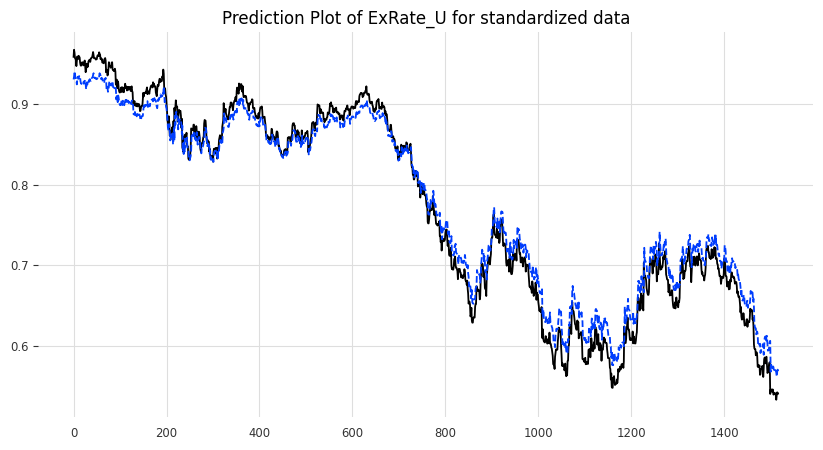

In [71]:
# #############################
# Plot prediction
# #############################

import matplotlib.pyplot as plt 


plt.figure(figsize=(10,5))
plt.plot(y_test)
plt.plot(y_pred,linestyle="--")
# plt.legend()
plt.title(f"Prediction Plot of {i} for standardized data")
plt.show()